In [181]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


In [ ]:
FLAT, SANDY, ROCK, CLIFF, TRAP, HAZARDOUS = "flat", "sandy", "rock", "cliff", "trap", "hazardous"

TERRAIN_COST = {
    FLAT: 5.0,
    SANDY: 10.0,
    ROCK: 1e6,
    CLIFF: 1e6,
    TRAP: 15.0,
    HAZARDOUS: 15.0
}

TERRAIN_UTILITY = {
    FLAT: 1,
    SANDY: 2,
    TRAP: -5,
    HAZARDOUS: 10,
    ROCK: -999,
    CLIFF: -999
}


In [183]:
def get_utility(tile):
    return TERRAIN_UTILITY.get(tile, 0)


In [184]:
GRID_SIZE = 20

TERRAIN_LIST = [FLAT, SANDY, ROCK, CLIFF, TRAP, HAZARDOUS]
TERRAIN_WEIGHTS = [0.4, 0.25, 0.1, 0.1, 0.075, 0.075]

def generate_random_grid():
    return [
        random.choices(TERRAIN_LIST, weights=TERRAIN_WEIGHTS, k=GRID_SIZE)
        for _ in range(GRID_SIZE)
    ]


In [ ]:
def manhattan(a, b, grid=None):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def euclidean(a, b, grid=None):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def terrain_aggressive(a, b, grid):
    (r1,c1),(r2,c2)=a,b
    d = math.hypot(r1-r2,c1-c2)
    steps = max(int(math.ceil(d*2)),1)
    tot = 0; cnt = 0
    for t in range(steps+1):
        alpha = t/steps
        rr = int(round(r1*(1-alpha)+r2*alpha))
        cc = int(round(c1*(1-alpha)+c2*alpha))
        if 0<=rr<GRID_SIZE and 0<=cc<GRID_SIZE:
            tot += min(TERRAIN_COST[grid[rr][cc]], 1000)
            cnt+=1
    return d * (tot/cnt if cnt else TERRAIN_COST[FLAT])

def adaptive_h1(current, goal, grid=None):
    return 5.0 * (abs(current[0]-goal[0]) + abs(current[1]-goal[1]))

def obstacle_aversion_h2(current, goal, grid):
    base = adaptive_h1(current, goal)
    r, c = current
    best = float("inf")

    for rr in range(GRID_SIZE):
        for cc in range(GRID_SIZE):
            if grid[rr][cc] in [ROCK, CLIFF]:
                d = (r-rr)**2 + (c-cc)**2
                best = min(best, d)

    if best == float("inf"):
        return base

    best = max(best, 0.25)
    return base + 10*(1/best)

HEURISTICS = {
    "Manhattan": manhattan,
    "Euclidean": euclidean,
    "Terrain Aggressive": terrain_aggressive,
    "Adaptive H1": adaptive_h1,
    "Obstacle Aversion H2": obstacle_aversion_h2
}


In [186]:
def in_bounds(r, c):
    return 0 <= r < GRID_SIZE and 0 <= c < GRID_SIZE

def neighbors_4(r, c):
    return [(r-1,c),(r+1,c),(r,c-1),(r,c+1)]


In [187]:
import heapq

def astar_cost_only(grid, start, goal, hfn):
    (sr, sc), (gr, gc) = start, goal
    pq=[]
    heapq.heappush(pq,(0,0,start))
    g={start:0}
    came={}
    explored=0

    while pq:
        _, gcost, (r,c) = heapq.heappop(pq)
        explored+=1

        if (r,c) == (gr,gc):
            path=[(r,c)]
            while path[-1] in came:
                path.append(came[path[-1]])
            return path[::-1], explored, g[(r,c)]

        for nr, nc in neighbors_4(r,c):
            if not in_bounds(nr, nc):
                continue
            tile = grid[nr][nc]
            if TERRAIN_COST[tile] >= 1e6:
                continue

            step_cost = TERRAIN_COST[tile]
            new_g = gcost + step_cost

            if new_g < g.get((nr,nc), float('inf')):
                g[(nr,nc)] = new_g
                came[(nr,nc)] = (r,c)
                f = new_g + hfn((nr,nc), goal, grid)
                heapq.heappush(pq,(f,new_g,(nr,nc)))

    return None, explored, float('inf')


In [188]:
def astar_utility(grid, start, goal, hfn):
    (sr, sc), (gr, gc) = start, goal
    pq=[]
    heapq.heappush(pq,(0,0,start))
    g={start:0}
    came={}
    explored=0

    while pq:
        _, gcost, (r,c) = heapq.heappop(pq)
        explored+=1

        if (r,c) == (gr,gc):
            path=[(r,c)]
            while path[-1] in came:
                path.append(came[path[-1]])
            return path[::-1], explored, g[(r,c)]

        for nr, nc in neighbors_4(r,c):
            if not in_bounds(nr, nc):
                continue

            tile = grid[nr][nc]
            if TERRAIN_COST[tile] >= 1e6:
                continue

            base_cost = TERRAIN_COST[tile]
            utility_gain = get_utility(tile)

            move_cost = base_cost - utility_gain

            new_g = gcost + move_cost

            if new_g < g.get((nr,nc), float('inf')):
                g[(nr,nc)] = new_g
                came[(nr,nc)] = (r,c)
                f = new_g + hfn((nr,nc), goal, grid)
                heapq.heappush(pq,(f,new_g,(nr,nc)))

    return None, explored, float('inf')


In [189]:
def run_comparison(num_trials=10):
    rows = []

    for t in range(num_trials):
        grid = generate_random_grid()
        start, goal = (0,0), (GRID_SIZE-1, GRID_SIZE-1)

        for name, hfn in HEURISTICS.items():

            # STANDARD A*
            t0 = time.time()
            path1, expl1, cost1 = astar_cost_only(grid, start, goal, hfn)
            t1 = time.time()

            # UTILITY A*
            t2 = time.time()
            path2, expl2, cost2 = astar_utility(grid, start, goal, hfn)
            t3 = time.time()

            rows.append({
                "Trial": t+1,
                "Heuristic": name,

                # STANDARD
                "Std Path Length": len(path1) if path1 else None,
                "Std Total Cost": cost1,
                "Std Nodes": expl1,
                "Std Time": round(t1-t0,5),

                # UTILITY
                "Util Path Length": len(path2) if path2 else None,
                "Util Total Cost": cost2,
                "Util Nodes": expl2,
                "Util Time": round(t3-t2,5)
            })

    return pd.DataFrame(rows)


In [190]:
df = run_comparison(num_trials=10)
display(df)


,Trial,Heuristic,Std Path Length,Std Total Cost,Std Nodes,Std Time,Util Path Length,Util Total Cost,Util Nodes,Util Time
0,1,Manhattan,39.0,245.0,313,0.00200,39.0,197.0,308,0.00100
1,1,Euclidean,39.0,245.0,313,0.00132,39.0,197.0,308,0.00149
2,1,Terrain Aggressive,43.0,350.0,66,0.00402,45.0,283.0,62,0.00300
3,1,Adaptive H1,39.0,245.0,235,0.00000,39.0,197.0,108,0.00100
4,1,Obstacle Aversion H2,39.0,245.0,260,0.01400,39.0,197.0,128,0.00802
5,2,Manhattan,39.0,250.0,330,0.00099,39.0,185.0,330,0.00100
6,2,Euclidean,39.0,250.0,330,0.00100,39.0,185.0,330,0.00098
7,2,Terrain Aggressive,41.0,290.0,66,0.00202,41.0,219.0,67,0.00299
8,2,Adaptive H1,39.0,250.0,295,0.00100,39.0,185.0,141,0.00000
9,2,Obstacle Aversion H2,39.0,250.0,282,0.01600,39.0,185.0,151,0.00900


In [191]:
df_success = df[df["Std Total Cost"] != float("inf")]
df_success = df_success[df_success["Util Total Cost"] != float("inf")]

display(Markdown("Successful Trials Only"))
display(df_success)


Successful Trials Only

,Trial,Heuristic,Std Path Length,Std Total Cost,Std Nodes,Std Time,Util Path Length,Util Total Cost,Util Nodes,Util Time
0,1,Manhattan,39.0,245.0,313,0.00200,39.0,197.0,308,0.00100
1,1,Euclidean,39.0,245.0,313,0.00132,39.0,197.0,308,0.00149
2,1,Terrain Aggressive,43.0,350.0,66,0.00402,45.0,283.0,62,0.00300
3,1,Adaptive H1,39.0,245.0,235,0.00000,39.0,197.0,108,0.00100
4,1,Obstacle Aversion H2,39.0,245.0,260,0.01400,39.0,197.0,128,0.00802
5,2,Manhattan,39.0,250.0,330,0.00099,39.0,185.0,330,0.00100
6,2,Euclidean,39.0,250.0,330,0.00100,39.0,185.0,330,0.00098
7,2,Terrain Aggressive,41.0,290.0,66,0.00202,41.0,219.0,67,0.00299
8,2,Adaptive H1,39.0,250.0,295,0.00100,39.0,185.0,141,0.00000
9,2,Obstacle Aversion H2,39.0,250.0,282,0.01600,39.0,185.0,151,0.00900


In [192]:
summary = df_success.groupby("Heuristic").agg({
    "Std Total Cost": "mean",
    "Std Nodes": "mean",
    "Std Time": "mean",
    "Util Total Cost": "mean",
    "Util Nodes": "mean",
    "Util Time": "mean"
}).reset_index()

display(Markdown("Average Results per Heuristic (Cost A* vs Utility A*)"))
display(summary)


Average Results per Heuristic (Cost A* vs Utility A*)

,Heuristic,Std Total Cost,Std Nodes,Std Time,Util Total Cost,Util Nodes,Util Time
0,Adaptive H1,268.75,292.375,0.000753,204.75,188.000,0.000506
1,Euclidean,268.75,315.750,0.000791,204.75,318.500,0.000983
2,Manhattan,268.75,315.625,0.000874,204.75,318.625,0.000999
3,Obstacle Aversion H2,268.75,300.375,0.015731,204.75,217.625,0.013024
4,Terrain Aggressive,326.25,71.250,0.002540,253.25,72.125,0.002746


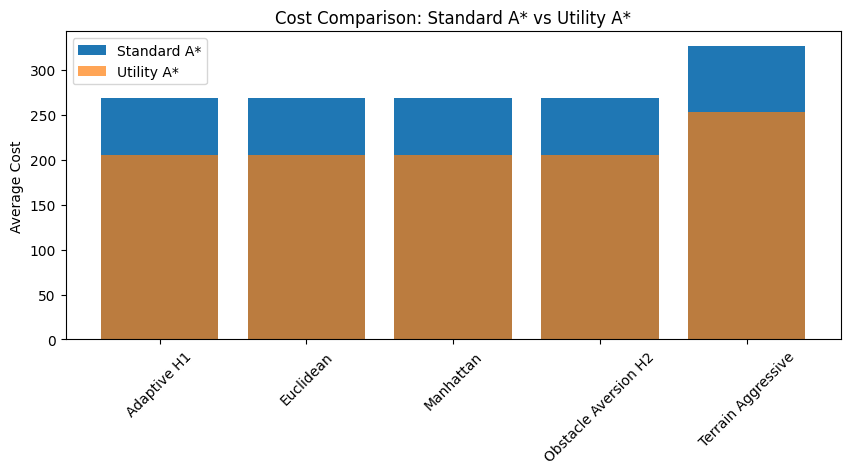

In [193]:
plt.figure(figsize=(10,4))
plt.bar(summary["Heuristic"], summary["Std Total Cost"], label="Standard A*")
plt.bar(summary["Heuristic"], summary["Util Total Cost"], label="Utility A*", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Average Cost")
plt.title("Cost Comparison: Standard A* vs Utility A*")
plt.legend()
plt.show()


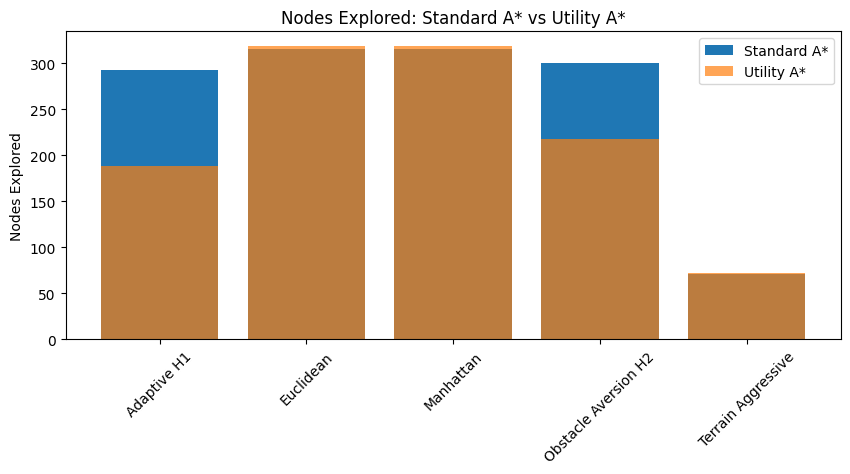

In [194]:
plt.figure(figsize=(10,4))
plt.bar(summary["Heuristic"], summary["Std Nodes"], label="Standard A*")
plt.bar(summary["Heuristic"], summary["Util Nodes"], label="Utility A*", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Nodes Explored")
plt.title("Nodes Explored: Standard A* vs Utility A*")
plt.legend()
plt.show()


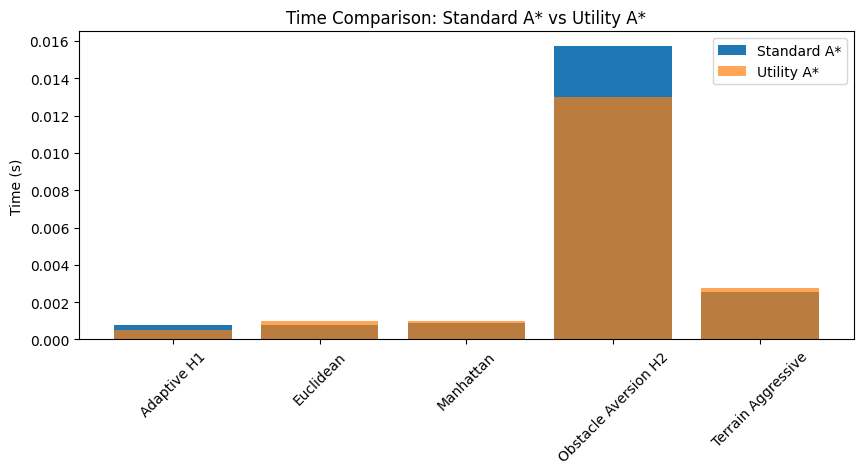

In [195]:
plt.figure(figsize=(10,4))
plt.bar(summary["Heuristic"], summary["Std Time"], label="Standard A*")
plt.bar(summary["Heuristic"], summary["Util Time"], label="Utility A*", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Time (s)")
plt.title("Time Comparison: Standard A* vs Utility A*")
plt.legend()
plt.show()
